## Scraping Twitter and cleaning the data

Variables in raw data:
- id - tweet id, type: long int,
- conversation_id  - conversation id, type: long int,
- created_at - tweet creation date, type: datetime,
- date - shortened tweet creation date, type: datetime,
- time - tweet creation time, type: datetime,
- timezone - scrapper timezone, type: int,
- user_id - tweeter's id, type: long int,
- username - user's unique name, type: text,
- name - user's name (changable by the user), type: text,
- place - mentioned places found, type: list of dictionaries,
- tweet - tweet, type: text,
- language - tweet language - country code, type: text,
- mentions - data of mentioned users, type: list of dictionaries,
- urls - urls found in tweet, type: list of strings,
- photos - photos' urls found in tweet, type: list of strings,
- replies_count - number of replies for tweet, type: int,
- retweets_count - number of retweets for tweet, type: int,
- likes_count - number of likes for tweet, type: int,
- hashtags - hashtags found in tweet, type: list of strings,
- cashtags - cashtags found in tweet, type: list of strings,
- link - tweet's link, type: string,
- retweet - is tweet a retweet? type: boolean,
- quote_url - url of original tweet (if retweet = True), type: string, 
- video - does the tweet contain a video? type: int,
- thumbnail - user's thumbnail url, type: string
- near - None
- geo - user's geographical coordinates, type: list of floats,
- source - html code of the tweet (if source = True while scraping), type: text,
- user_rt_id - user id of the original tweet (if retweet = True), type: long int
- user_rt - user's unique name (if retweet = True), type: text,
- retweet_id - tweet id (if retweet = True), type: long int,
- reply_to - data of users tweet replies to, type: list of dictionaries,
- retweet_date - date of retweet, (if retweet = True), type: datetime,
- translate - if tweet is translated or not, type: int,
- trans_src - original tweet to be translated (if translate = True while scraping), type: text,
- trans_dest - translated tweet (if translate = True while scraping), type: text,
- keyword - keyword used to scrap tweet, type: string

Additional variables introduced in feature engineering and nlp sections:
- tweet_length - length of tweet (in characters), type: int,
- num_mention' - number of mentions in tweet, type: int,
- num_urls - number of urls present in tweet, type: int,
- num_photos - number of photos attached in tweet, type: int,
- num_hashtags - number of hashtags in tweet, type: int,
- num_cashtags - number of cashtags in tweet, type: int,
- all_english_text - translated tweet, type: text,
- probability - probability of the label in `sentiment` variable, type: float,
- sentiment - tweet sentiment analysis result, type: text.

## Imports and constants

In [ ]:
# !pip install nest_asyncio
# !pip install ipywidgets widgetsnbextension pandas-profiling
# !pip install emoji
# !jupyter nbextension enable --py widgetsnbextension

In [ ]:
# standard library
import time
import string 
import re
import random

# data manipulation
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# tweet scrapping
import twint
import nest_asyncio

# Deep Learning libraries
import torch
import torch.nn as nn

import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, pipeline
from datasets import list_metrics, load_metric

# other libraries
import shap
from scipy.special import softmax

In [ ]:
pd.options.display.max_rows = 40
pd.options.display.max_columns = 40

nest_asyncio.apply()

In [ ]:
RAW_DATA_PATH = 'data/raw/'
PROCESSED_DATA_PATH = 'data/processed/'

# full clean-up
PUN_CHARS = string.punctuation

# only trash, without !?,. since they are important for transformers
PUN_CHARS_LIGHT = '"#$%&\'()*+-/:;<=>@[\\]^_`{|}~'

## Scraping Twitter

First, we need to scrap some data from twitter - we decided on a couple of the most popular cryptocurrencies as well as a few terms related to crypto.

Since Twitter constantly changes their API, we'll use Twint, which doesn't require any developer credentials.

In [ ]:
twitter_searches = ['Bitcoin', 'Ethereum', 'Solana', 'Cardano', 'Dogecoin', 
                    'SHIB', 'Metaverse', 'nft', 'FUD']

In [ ]:
def scrap_keyword(keyword, tweet_limit, save_output=True):
#     config = twint.Config()
#     config.Search = keyword
#     config.Limit = tweet_limit
#     if save_output:
#         config.Store_csv = True
#         config.Output = f"{keyword.lower()}.csv"
    
#     twint.run.Search(config)
    print(f"Scraping {keyword} done!")

In [ ]:
for keyword in twitter_searches:
    scrap_keyword(keyword, 1500)

Scraping Bitcoin done!
Scraping Ethereum done!
Scraping Solana done!
Scraping Cardano done!
Scraping Dogecoin done!
Scraping SHIB done!
Scraping Metaverse done!
Scraping nft done!
Scraping FUD done!


## Initial look at data

Let's load in all of the available data.

In [ ]:
def load_files(keyword_list):
    all_the_data = []

    for keyword in keyword_list:
        curr_data = pd.read_csv(RAW_DATA_PATH + keyword.lower() + '.csv')
        # add a keyword column to easily differentiate datasets
        curr_data['keyword'] = keyword
        all_the_data.append(curr_data)

    concat_data = pd.concat(all_the_data, ignore_index=True)
    
    return concat_data

In [ ]:
raw_data = load_files(twitter_searches)
raw_data.shape

(21571, 37)

For now, we'll take a quick look at at our scraped data. We'll dive deeper after the preprocessing pipeline is applied to all of the datasets.

In [ ]:
raw_data.head(5)

id      conversation_id               created_at  \
0  1467581925078544391  1467581925078544391  2021-12-05 20:49:31 CET   
1  1467581922914222091  1467581922914222091  2021-12-05 20:49:31 CET   
2  1467581921014296579  1467581921014296579  2021-12-05 20:49:30 CET   
3  1467581912571125766  1467576059088543748  2021-12-05 20:49:28 CET   
4  1467581912013492224  1466432337705676818  2021-12-05 20:49:28 CET   

         date      time  timezone              user_id         username  \
0  2021-12-05  20:49:31       100   878016376354557954  satoshihoarder_   
1  2021-12-05  20:49:31       100           2262758048      eensargencc   
2  2021-12-05  20:49:30       100  1353825602411913216          btcsems   
3  2021-12-05  20:49:28       100  1294051456325169157      chardburned   
4  2021-12-05  20:49:28       100  1466362705498247168    angel13370372   

                 name place  \
0  satoshihoarder.btc   NaN   
1          Ensar Genç   NaN   
2           ŞemS 🏴‍☠️   NaN   
3         chardburned   NaN   
4               Fairy   NaN   

                                               tweet language  \
0  DCA is the ONLY way! #Bitcoin  https://t.co/z7...       en   
1  Trending on #LunarCrush:  "Reasons For Calm De...       en   
2  #Bitcoin Burdan Sekip 50.000$ Üzerine Atmalı  ...       tr   
3  @TheLastDegree Bitcoin+gold is the ultimate pl...       en   
4  @Bitcoinachu @cdixon @cameron The value of Bit...       en   

                                            mentions  \
0                                                 []   
1  [{'screen_name': 'forbes', 'name': 'forbes', '...   
2                                                 []   
3                                                 []   
4                                                 []   

                           urls  \
0                            []   
1  ['https://lnr.app/s/RNxwx2']   
2                            []   
3                            []   
4                            []   

                                              photos  replies_count  \
0  ['https://pbs.twimg.com/media/FF3l-38XwAQsgBa....              0   
1                                                 []              0   
2  ['https://pbs.twimg.com/media/FF3l-aXXIAAA40n....              0   
3                                                 []              0   
4                                                 []              0   

   retweets_count  likes_count  \
0               0            0   
1               0            0   
2               0            0   
3               0            0   
4               0            0   

                                            hashtags cashtags  \
0                                        ['bitcoin']       []   
1                       ['lunarcrush', 'lunarshare']  ['btc']   
2  ['bitcoin', 'dydx', 'link', 'sgb', 'floki', 'f...       []   
3                                                 []       []   
4                                                 []       []   

                                                link  retweet quote_url  \
0  https://twitter.com/satoshihoarder_/status/146...    False       NaN   
1  https://twitter.com/eensargencc/status/1467581...    False       NaN   
2  https://twitter.com/btcsems/status/14675819210...    False       NaN   
3  https://twitter.com/chardburned/status/1467581...    False       NaN   
4  https://twitter.com/Angel13370372/status/14675...    False       NaN   

   video                                        thumbnail  near  geo  source  \
0      1  https://pbs.twimg.com/media/FF3l-38XwAQsgBa.jpg   NaN  NaN     NaN   
1      0                                              NaN   NaN  NaN     NaN   
2      1  https://pbs.twimg.com/media/FF3l-aXXIAAA40n.jpg   NaN  NaN     NaN   
3      0                                              NaN   NaN  NaN     NaN   
4      0                                              NaN   NaN  NaN     NaN   

   user_rt_id  user_rt  retweet_id  \
0         NaN    

Looks like there are quite a lot of missing values here, some are just empty lists while others are NaNs. Let's take a look at what they are.

In [ ]:
def check_nulls(data):
    # prepare dataframe with num of null values and pct of all values
    null_dataframe = pd.DataFrame({"values_null": data.isnull().sum(), 
                                   "percentage_null": (data.isnull().sum() / data.shape[0] * 100)
                                  })
    return null_dataframe

In [ ]:
check_nulls(raw_data)

values_null  percentage_null
id                         0         0.000000
conversation_id            0         0.000000
created_at                 0         0.000000
date                       0         0.000000
time                       0         0.000000
timezone                   0         0.000000
user_id                    0         0.000000
username                   0         0.000000
name                       0         0.000000
place                  21569        99.990728
tweet                      0         0.000000
language                   0         0.000000
mentions                   0         0.000000
urls                       0         0.000000
photos                     0         0.000000
replies_count              0         0.000000
retweets_count             0         0.000000
likes_count                0         0.000000
hashtags                   0         0.000000
cashtags                   0         0.000000
link                       0         0.000000
retweet                    0         0.000000
quote_url              19540        90.584581
video                      0         0.000000
thumbnail              17978        83.343378
near                   21571       100.000000
geo                    21571       100.000000
source                 21571       100.000000
user_rt_id             21571       100.000000
user_rt                21571       100.000000
retweet_id             21571       100.000000
reply_to                   0         0.000000
retweet_date           21571       100.000000
translate              21571       100.000000
trans_src              21571       100.000000
trans_dest             21571       100.000000
keyword                    0         0.000000

We there are quite a lot of columns here, and the format is not easy to digest, so let's visualize missing values using a heatmap. Black colour indicates missing values.

In [ ]:
def visualize_nulls(data):
    plt.figure(figsize=(18,12))
    sns.heatmap(~data.isnull(), cbar=False, yticklabels=False)
    plt.xticks(rotation=90, size='x-large')
    plt.show()

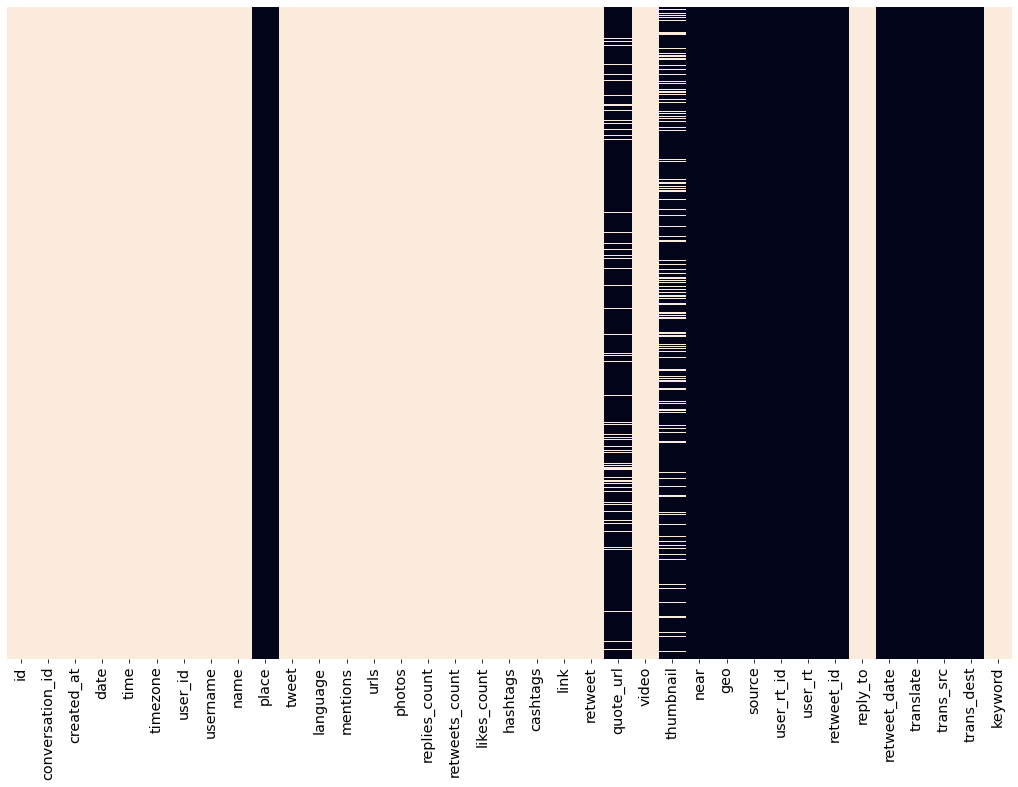

In [ ]:
visualize_nulls(raw_data)

While normally, we would be able to see some relationships between missing values, we know that this is not the case here, or at least they're not easily visible right now.

We'll delete any columns later on in the pipeline.

## Cleaning the data and other transformations

Let's take a look at other columns that don't have null data according to the heatmap. For the sake of cleanliness, only one check will be left here, but rest assured that every column was checked.

In [ ]:
raw_data.head(2)

id      conversation_id               created_at  \
0  1467581925078544391  1467581925078544391  2021-12-05 20:49:31 CET   
1  1467581922914222091  1467581922914222091  2021-12-05 20:49:31 CET   

         date      time  timezone             user_id         username  \
0  2021-12-05  20:49:31       100  878016376354557954  satoshihoarder_   
1  2021-12-05  20:49:31       100          2262758048      eensargencc   

                 name place  \
0  satoshihoarder.btc   NaN   
1          Ensar Genç   NaN   

                                               tweet language  \
0  DCA is the ONLY way! #Bitcoin  https://t.co/z7...       en   
1  Trending on #LunarCrush:  "Reasons For Calm De...       en   

                                            mentions  \
0                                                 []   
1  [{'screen_name': 'forbes', 'name': 'forbes', '...   

                           urls  \
0                            []   
1  ['https://lnr.app/s/RNxwx2']   

                                              photos  replies_count  \
0  ['https://pbs.twimg.com/media/FF3l-38XwAQsgBa....              0   
1                                                 []              0   

   retweets_count  likes_count                      hashtags cashtags  \
0               0            0                   ['bitcoin']       []   
1               0            0  ['lunarcrush', 'lunarshare']  ['btc']   

                                                link  retweet quote_url  \
0  https://twitter.com/satoshihoarder_/status/146...    False       NaN   
1  https://twitter.com/eensargencc/status/1467581...    False       NaN   

   video                                        thumbnail  near  geo  source  \
0      1  https://pbs.twimg.com/media/FF3l-38XwAQsgBa.jpg   NaN  NaN     NaN   
1      0                                              NaN   NaN  NaN     NaN   

   user_rt_id  user_rt  retweet_id reply_to  retweet_date  translate  \
0         NaN      NaN         NaN       []           NaN        NaN   
1         NaN      NaN         NaN       []           NaN        NaN   

   trans_src  trans_dest  keyword  
0        NaN         NaN  Bitcoin  
1        NaN         NaN  Bitcoin

Oddly enough, some of our data will still have missing values such as empty lists - let's take a closer look at `mentions`, `urls`, `photos`, `hashtags`, `cashtags`, and `reply_to`.

In [ ]:
def check_empty_lists(data, colname):
    missing_data = data[data[colname] == '[]'].shape[0] 
    missing_pct = round((missing_data/ data.shape[0]) * 100, 2)
    print(f"For {colname}, there are {missing_data} empty list values, which account for {missing_pct}% of data.")

In [ ]:
cols_to_check = ['mentions', 'urls', 'photos', 'hashtags', 'cashtags', 'reply_to']

for col in cols_to_check:
    check_empty_lists(raw_data, col)

For mentions, there are 15092 empty list values, which account for 69.96% of data.
For urls, there are 17203 empty list values, which account for 79.75% of data.
For photos, there are 18351 empty list values, which account for 85.07% of data.
For hashtags, there are 8846 empty list values, which account for 41.01% of data.
For cashtags, there are 18527 empty list values, which account for 85.89% of data.
For reply_to, there are 11525 empty list values, which account for 53.43% of data.


Looks like there are a couple of columns here that we can utilise in our analysis - `mentions`, `urls`, `photos`, `hastags` and `cashtags`. Since all of them are saved as strings and we won't use the actual values, let's count in the number of occurences for each of them.

For `mentions`, we'll count number of `:` in string, where three colons are equal to one mention. for `urls` and `photos`, we'll count number of `https`. And last but not least, for hashtags and cashtags we'll count the number of `,` - if there's 0 and string is only `[]`, it'll be zero tags, longer strings with 0 occurences will be a single tag and so on.

### Light feature engineering

Additionally, we can add tweet length to check whether these are short thoughts/news or longer rants.

In [ ]:
def count_tags(tags_string):
    string_len = len(tags_string)
    colon_count = tags_string.count(",")
    
    # apply logic described above
    if string_len <= 2:
        num_tags = 0
    elif (string_len > 2) & (colon_count == 0):
        num_tags = 1
    else:
        num_tags = colon_count + 1
        
    return num_tags

In [ ]:
def run_feature_pipeline(data, return_new = False):
    # add tweet length to dataset
    data['tweet_length'] = data['tweet'].map(lambda x: len(x))
    
    # add number of mentions, urls, photos, hashtags and cashtags to dataset
    data['num_mentions'] = data['mentions'].map(lambda x: int((x.count(":"))/3))
    data['num_urls'] = data['urls'].map(lambda x: x.count("https"))
    data['num_photos'] = data['photos'].map(lambda x: x.count("https"))
    data['num_hashtags'] = data['hashtags'].map(count_tags)
    data['num_cashtags'] = data['cashtags'].map(count_tags)
    
    if return_new:
        return data

### Data removal

Now that we extracted everything we wanted, let's remove columns that won't be used and any duplicates.

In [ ]:
cols_to_drop = ['conversation_id', 'created_at', 'user_id', 'mentions', 'urls', 
                'photos', 'hashtags', 'cashtags', 'reply_to', 'link', 'place', 
                'quote_url', 'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 
                'user_rt', 'retweet_id', 'retweet_date', 'translate', 'trans_src', 
                'trans_dest', 'timezone']

In [ ]:
def remove_data(data, columns_list=cols_to_drop):
    # remove unnecessary columns
    data.drop(columns_list, axis = 1, inplace = True)
    
    # remove duplicate tweets (if there are any)
    data.drop_duplicates(inplace = True, subset = "tweet")

### Cleaning up text data

Time to clean up the tweets, some of the things we need to take care of include:
- links in various forms,
- users,
- hashtags

In [ ]:
def remove_links(tweet):
    # remove http, bitly, pic.twitter and [] links
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'bit.ly/\S+', '', tweet)
    tweet = tweet.strip('[link]')
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    
    return tweet

In [ ]:
def remove_users(tweet):
    # remove users
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)
    
    return tweet

After analyzing the tweets further, we noticed a lot of hashtags are used inside sentences, e.g.: 

`"I just bought #Bitcoin, I'm ready to become a millionaire overnight!"`

Removing the hashtag would mean the sentence is deprived of it's core. Due to this issue, the hashtags won't be removed, only the `#` symbol itself (taken care of later, with punctuation.)

In [ ]:
def remove_hashtags(tweet):
    # remove hashtags
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)
    
    return tweet

In [ ]:
def clean_up_characters(tweet, punctuation=PUN_CHARS, keep_lower=False):
    # remove punctuation, excess spacing, numbers
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)
    tweet = re.sub('\s+', ' ', tweet)
    # we won't remove numbers right now, since they might be useful for transformers
    # tweet = re.sub('([0-9]+)', '', tweet)
    
    # apply lowercase
    if keep_lower:
        tweet = tweet.lower()
    
    return tweet

We could do it multiple different ways, this will get rid of everything. Depending on what model we use, we might want to leave emojis in here, since some of the models can handle emojis on their own.

In [ ]:
def remove_emojis(tweet):
    # remove all unicode characters
    tweet = tweet.encode('ascii', 'ignore').decode('ascii')
    
    return tweet

To use transformers, we also have to limit tweet length to 128 characters.

In [ ]:
def limit_tweet_length(tweet, max_length=128):
    if len(tweet) > max_length:
        tweet = tweet[:max_length]
    
    return tweet

Let's wrap all of these in a single function

In [ ]:
def run_processing_pipeline(tweet, full_clean=False):
    # apply all the processing steps
    tweet = limit_tweet_length(tweet)
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)

    if full_clean:
        tweet = remove_hashtags(tweet)

    tweet = remove_emojis(tweet)
    
    tweet = clean_up_characters(tweet, PUN_CHARS_LIGHT)
        
    return tweet

### Running the whole data processing pipeline

At last, let's run the whole pipeline 

In [ ]:
def run_pipeline_on_data(data, output_col='processed_tweet', filter_lang=True, languages=['en']):
    # run the whole pipeline and time it
    start = time.time()
    print("Pipeline started...")
    
    run_feature_pipeline(data)
    print("Feature pipeline finished. New features added.")
    
    # to use transformers later on, we have to limit the length to 128 characters
    # data = data[data['tweet_length'] <= 128].copy()
    remove_data(data)
    print("Removal of unnecessary data finished.")
    
    if filter_lang:
        data = data[data['language'].isin(languages)].copy()
        print("Languages filtered.")
    
    data[output_col] = data['tweet'].map(run_processing_pipeline)
    print("Text processing pipeline finished.")
    
    end = time.time()
    elapsed_time = end - start
    print(f"Pipeline finished in {round(elapsed_time, 2)} seconds.")
    
    return data

Since we want to do some translation, we'll limit languages to include not only english, but spanish as well.

In [ ]:
clean_data = run_pipeline_on_data(raw_data.copy(), 'processed_tweet', True, ['en', 'es'])

Pipeline started...
Feature pipeline finished. New features added.
Removal of unnecessary data finished.
Languages filtered.
Text processing pipeline finished.
Pipeline finished in 0.34 seconds.


Now let's see a before and after:

In [ ]:
clean_data.head(3)

id        date      time         username  \
0  1467581925078544391  2021-12-05  20:49:31  satoshihoarder_   
1  1467581922914222091  2021-12-05  20:49:31      eensargencc   
3  1467581912571125766  2021-12-05  20:49:28      chardburned   

                 name                                              tweet  \
0  satoshihoarder.btc  DCA is the ONLY way! #Bitcoin  https://t.co/z7...   
1          Ensar Genç  Trending on #LunarCrush:  "Reasons For Calm De...   
3         chardburned  @TheLastDegree Bitcoin+gold is the ultimate pl...   

  language  replies_count  retweets_count  likes_count  retweet  video  \
0       en              0               0            0    False      1   
1       en              0               0            0    False      0   
3       en              0               0            0    False      0   

   keyword  tweet_length  num_mentions  num_urls  num_photos  num_hashtags  \
0  Bitcoin            54             0         0           1             1   
1  Bitcoin           159             1         1           0             2   
3  Bitcoin            91             0         0           0             0   

   num_cashtags                                    processed_tweet  
0             0                      DCA is the ONLY way! Bitcoin   
1             1  Trending on LunarCrush Reasons For Calm Despit...  
3             0   Bitcoin gold is the ultimate play Its the per...

Let's check a sample tweet before and after processing

In [ ]:
before = clean_data.loc[0,'tweet']
after = clean_data.loc[0,'processed_tweet']
print(f'Before applying the clean-up pipeline: {before}, \nAfter applying the clean-up pipeline: {after}')

Before applying the clean-up pipeline: DCA is the ONLY way! #Bitcoin  https://t.co/z7KltRbRrH, 
After applying the clean-up pipeline: DCA is the ONLY way! Bitcoin 


Time to move on to some exploratory analysis

## Some exploratory analysis

Although it might be quite messy, we'll take a look at both cleaned and raw datasets, since they have different columns and values present.

### Raw data with applied feature engineering

Since we want to analyze a few on the newly established features for all the languages, we'll have to do so on a separate dataset - the clean version has to get rid of all but two languages and other unnecessary features.

In [ ]:
enhanced_raw_data = run_feature_pipeline(raw_data, True)
enhanced_raw_data.head(5)

id      conversation_id               created_at  \
0  1467581925078544391  1467581925078544391  2021-12-05 20:49:31 CET   
1  1467581922914222091  1467581922914222091  2021-12-05 20:49:31 CET   
2  1467581921014296579  1467581921014296579  2021-12-05 20:49:30 CET   
3  1467581912571125766  1467576059088543748  2021-12-05 20:49:28 CET   
4  1467581912013492224  1466432337705676818  2021-12-05 20:49:28 CET   

         date      time  timezone              user_id         username  \
0  2021-12-05  20:49:31       100   878016376354557954  satoshihoarder_   
1  2021-12-05  20:49:31       100           2262758048      eensargencc   
2  2021-12-05  20:49:30       100  1353825602411913216          btcsems   
3  2021-12-05  20:49:28       100  1294051456325169157      chardburned   
4  2021-12-05  20:49:28       100  1466362705498247168    angel13370372   

                 name place  \
0  satoshihoarder.btc   NaN   
1          Ensar Genç   NaN   
2           ŞemS 🏴‍☠️   NaN   
3         chardburned   NaN   
4               Fairy   NaN   

                                               tweet language  \
0  DCA is the ONLY way! #Bitcoin  https://t.co/z7...       en   
1  Trending on #LunarCrush:  "Reasons For Calm De...       en   
2  #Bitcoin Burdan Sekip 50.000$ Üzerine Atmalı  ...       tr   
3  @TheLastDegree Bitcoin+gold is the ultimate pl...       en   
4  @Bitcoinachu @cdixon @cameron The value of Bit...       en   

                                            mentions  \
0                                                 []   
1  [{'screen_name': 'forbes', 'name': 'forbes', '...   
2                                                 []   
3                                                 []   
4                                                 []   

                           urls  \
0                            []   
1  ['https://lnr.app/s/RNxwx2']   
2                            []   
3                            []   
4                            []   

                                              photos  replies_count  \
0  ['https://pbs.twimg.com/media/FF3l-38XwAQsgBa....              0   
1                                                 []              0   
2  ['https://pbs.twimg.com/media/FF3l-aXXIAAA40n....              0   
3                                                 []              0   
4                                                 []              0   

   retweets_count  likes_count  \
0               0            0   
1               0            0   
2               0            0   
3               0            0   
4               0            0   

                                            hashtags cashtags  ... video  \
0                                        ['bitcoin']       []  ...     1   
1                       ['lunarcrush', 'lunarshare']  ['btc']  ...     0   
2  ['bitcoin', 'dydx', 'link', 'sgb', 'floki', 'f...       []  ...     1   
3                                                 []       []  ...     0   
4                                                 []       []  ...     0   

                                         thumbnail near  geo source  \
0  https://pbs.twimg.com/media/FF3l-38XwAQsgBa.jpg  NaN  NaN    NaN   
1                                              NaN  NaN  NaN    NaN   
2  https://pbs.twimg.com/media/FF3l-aXXIAAA40n.jpg  NaN  NaN    NaN   
3                                              NaN  NaN  NaN    NaN   
4                                              NaN  NaN  NaN    NaN   

   user_rt_id  user_rt  retweet_id  \
0         NaN      NaN         NaN   
1         NaN      NaN         NaN   
2         NaN      NaN         NaN   
3         NaN      NaN         NaN   
4         NaN      NaN         NaN   

                                            reply_to  retweet_date  translate  \
0                                                 []           NaN        NaN   
1                                                 []           NaN        NaN   
2                     

#### Hashtags and Cashtags by keyword

Let's take a look at number of hash/cash tags and mentions by keyword.

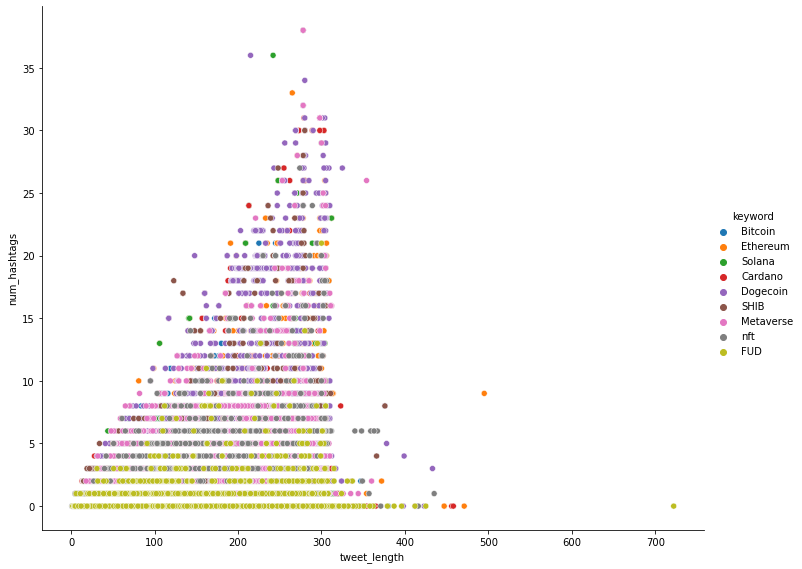

In [ ]:
sns.relplot(x="tweet_length", y="num_hashtags", hue="keyword", data=enhanced_raw_data, height=8, aspect=10/8);

We can see that by far the highest number of hashtags (and longest tweets) are about dogecoin - to better ilustrate this, let's take a look at individual plots to confirm this.

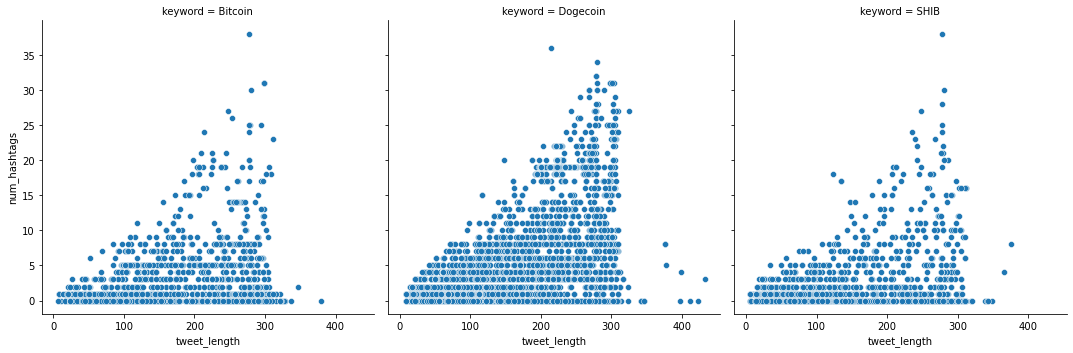

In [ ]:
sns.relplot(
    data=enhanced_raw_data[enhanced_raw_data['keyword'].isin(['Bitcoin', 'Dogecoin', 'SHIB'])], 
    x="tweet_length", y="num_hashtags",
    col="keyword", kind="scatter"
)

This could indicate that there's a lot of spam in dogecoin-related tweets. Let's move on to cashtags.

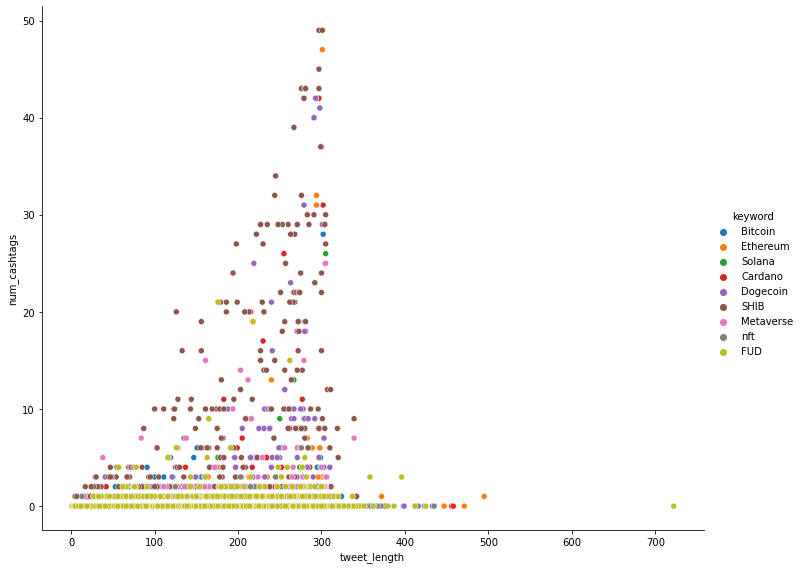

In [ ]:
sns.relplot(x="tweet_length", y="num_cashtags", hue="keyword", data=enhanced_raw_data, height=8, aspect=10/8);

SHIB has by far the highest number of cashtags.

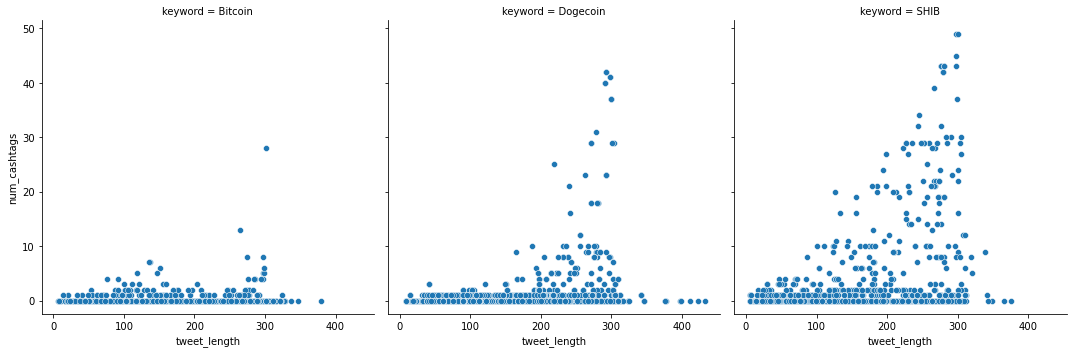

In [ ]:
sns.relplot(
    data=enhanced_raw_data[enhanced_raw_data['keyword'].isin(['Bitcoin', 'Dogecoin', 'SHIB'])], 
    x="tweet_length", y="num_cashtags",
    col="keyword", kind="scatter"
)

Both of our findings make sense, since Dogecoin and SHIB are both "memecoins" that sky rocketed in price and popularity in a matter of weeks just to plummet and leave a lot of people late to the hype train with huge losses.

To confirm our hypothesis, let's take a look at number of tweets with any number of hashtags, cashtags or mentions.

In [ ]:
non_zero_tags = enhanced_raw_data[(enhanced_raw_data['num_hashtags'] != 0) | 
                  (enhanced_raw_data['num_cashtags'] != 0) |
                  (enhanced_raw_data['num_mentions'] != 0)]

<AxesSubplot:>

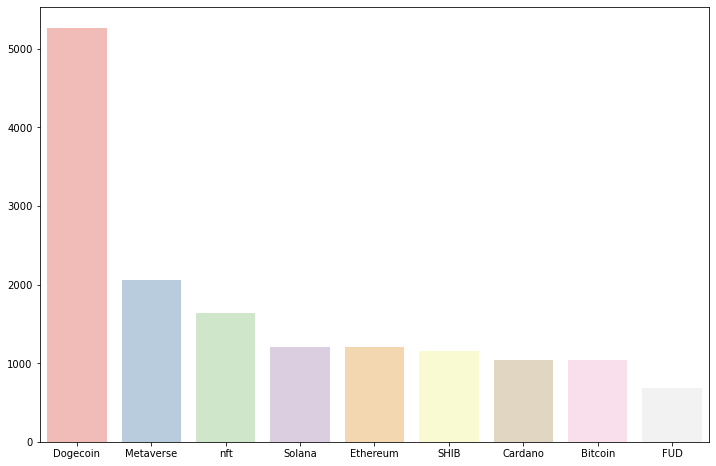

In [ ]:
kwrd_counts = list(non_zero_tags['keyword'].value_counts())
kwrd_labels = list(non_zero_tags['keyword'].value_counts().index)

plt.figure(figsize=(12, 8))
sns.barplot(x=kwrd_labels, y=kwrd_counts ,palette="Pastel1")

It appears that metaverse related topics are also quite "spammy".

In [ ]:
above_5_tags = enhanced_raw_data[(enhanced_raw_data['num_hashtags'] >= 5) | 
                  (enhanced_raw_data['num_cashtags'] >= 5) |
                  (enhanced_raw_data['num_mentions'] >= 5)]

<AxesSubplot:>

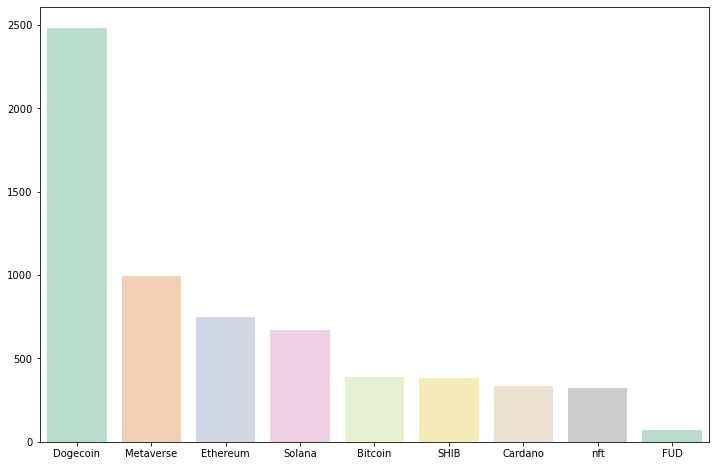

In [ ]:
kwrd_counts = list(above_5_tags['keyword'].value_counts())
kwrd_labels = list(above_5_tags['keyword'].value_counts().index)

plt.figure(figsize=(12, 8))
sns.barplot(x=kwrd_labels, y=kwrd_counts ,palette="Pastel2")

Looks like the situation repeats itself and Metaverse is again one of the most "spammy" topics - this once again makes sense, since it's something that's in the spotlight right now.

#### Languages

How about languages found in our data?

In [ ]:
round(raw_data['language'].value_counts(normalize=True, dropna=False) * 100, 2)

en     72.99
und    14.99
tr      2.86
es      1.53
in      1.32
       ...  
hu      0.01
lt      0.00
iw      0.00
el      0.00
bg      0.00
Name: language, Length: 41, dtype: float64

There are over 40 languages found with english being by far the most dominant. Let's take a look at top ten most popular

<AxesSubplot:>

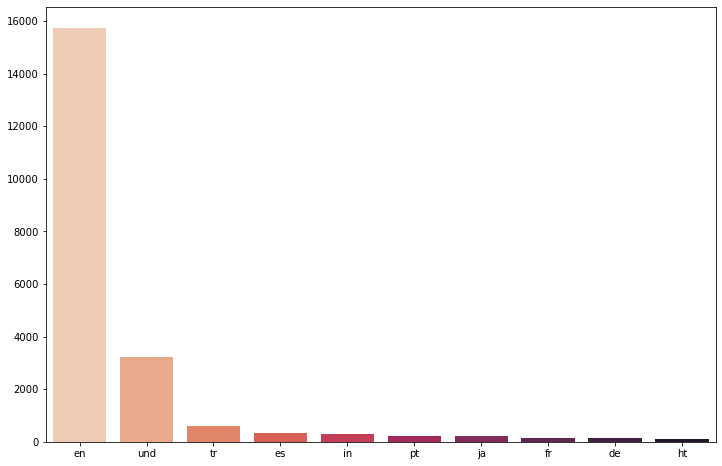

In [ ]:
lang_counts = list(enhanced_raw_data['language'].value_counts()[:10])
lang_labels = list(enhanced_raw_data['language'].value_counts()[:10].index)

plt.figure(figsize=(12, 8))
sns.barplot(x=lang_labels, y=lang_counts ,palette="rocket_r")

Unsurprisingly, english dominates, but we also have a lot of undetected language, let's take a look at the tweets.

In [ ]:
enhanced_raw_data[enhanced_raw_data['language'] == 'und']['tweet'][:10]

19     @NsuRcoin #Giveaway #cryptocurrency #Blockchai...
22     @bitcoin_brown @macromonetarist  https://t.co/...
34     #Bitcoin #BlockchainHueState #BlockHight &gt; ...
75     #Bitcoin #BitMart #shiba #dogecoin #Ethereum  ...
96     @NsuRcoin #Giveaway #cryptocurrency #Blockchai...
100                              https://t.co/aScH9ZPTri
103    #businessman #blogger #tumblr #twitter #facebo...
104    #businessman #bitcoin #tumblr #twitter #facebo...
105    #businessman #tumblr #twitter #facebook #insta...
108    #crypto #bitcoin #cryptocurrency #blockchain #...
Name: tweet, dtype: object

It appears, that these are just spam, since they only consist of hashtags and mentions. 

In [ ]:
undetected_lang_df = enhanced_raw_data[enhanced_raw_data['language'] == 'und']

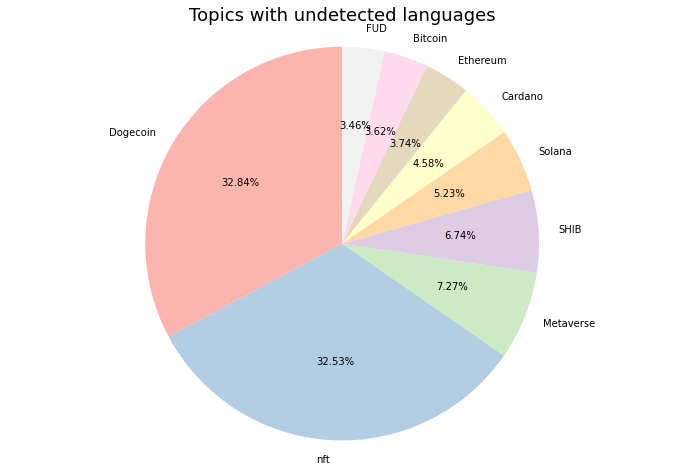

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
lang_counts = list(undetected_lang_df['keyword'].value_counts()[:10])
lang_labels = list(undetected_lang_df['keyword'].value_counts()[:10].index)

sns_colors = sns.color_palette('Pastel1')[0:9]

ax.pie(x=lang_counts, labels=lang_labels, colors=sns_colors, autopct='%1.2f%%', startangle=90)
ax.axis('equal')
ax.set_title('Topics with undetected languages', fontsize=18)

plt.show()

Dogecoin and nft account for over 65% of tweets with undetected language! This could further indicate that there's a lot of spam in these topics.

### Clean data

For the next part, let's take a look at cleaned data - this will only include english and spanish tweets.

In [ ]:
clean_data.head(5)

id        date      time         username  \
0  1467581925078544391  2021-12-05  20:49:31  satoshihoarder_   
1  1467581922914222091  2021-12-05  20:49:31      eensargencc   
3  1467581912571125766  2021-12-05  20:49:28      chardburned   
4  1467581912013492224  2021-12-05  20:49:28    angel13370372   
5  1467581911203815432  2021-12-05  20:49:28     pascalnajadi   

                 name                                              tweet  \
0  satoshihoarder.btc  DCA is the ONLY way! #Bitcoin  https://t.co/z7...   
1          Ensar Genç  Trending on #LunarCrush:  "Reasons For Calm De...   
3         chardburned  @TheLastDegree Bitcoin+gold is the ultimate pl...   
4               Fairy  @Bitcoinachu @cdixon @cameron The value of Bit...   
5       Pascal Najadi  #Bitcoin can be stored for 1000.years without ...   

  language  replies_count  retweets_count  likes_count  retweet  video  \
0       en              0               0            0    False      1   
1       en              0               0            0    False      0   
3       en              0               0            0    False      0   
4       en              0               0            0    False      0   
5       en              0               0            0    False      0   

   keyword  tweet_length  num_mentions  num_urls  num_photos  num_hashtags  \
0  Bitcoin            54             0         0           1             1   
1  Bitcoin           159             1         1           0             2   
3  Bitcoin            91             0         0           0             0   
4  Bitcoin            97             0         0           0             0   
5  Bitcoin            58             0         0           0             1   

   num_cashtags                                    processed_tweet  
0             0                      DCA is the ONLY way! Bitcoin   
1             1  Trending on LunarCrush Reasons For Calm Despit...  
3             0   Bitcoin gold is the ultimate play Its the per...  
4             0   The value of Bitcoin can fluctuate while the ...  
5             0   Bitcoin can be stored for 1000 years without ...

#### Tweet length distribution

First, let's check the tweet length distribution

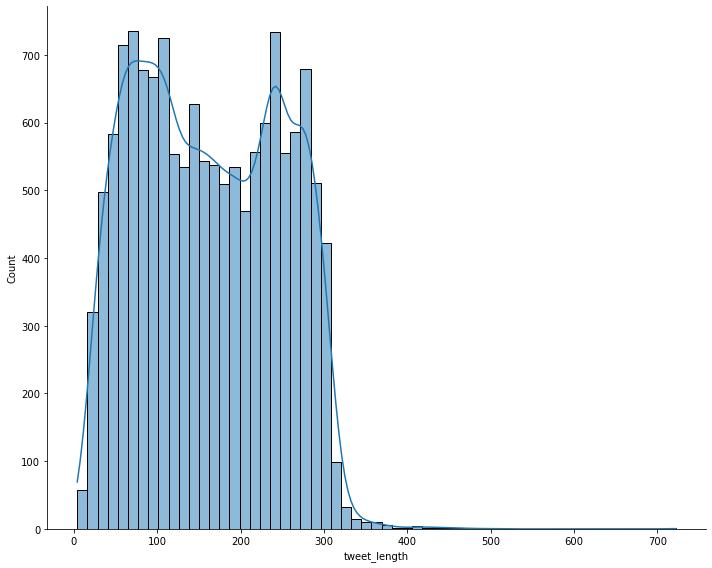

In [ ]:
sns.displot(clean_data['tweet_length'], kde=True, height=8, aspect=10/8)

There are two peaks in the distribution:
- between 0 and 100, at around 70 characters
- and between 200 and 300, at around 250 characters

#### Average tweet length by keyword

[Text(0, 0, 'Ethereum'),
 Text(1, 0, 'Metaverse'),
 Text(2, 0, 'Bitcoin'),
 Text(3, 0, 'Solana'),
 Text(4, 0, 'Cardano'),
 Text(5, 0, 'Dogecoin'),
 Text(6, 0, 'FUD'),
 Text(7, 0, 'SHIB'),
 Text(8, 0, 'nft')]

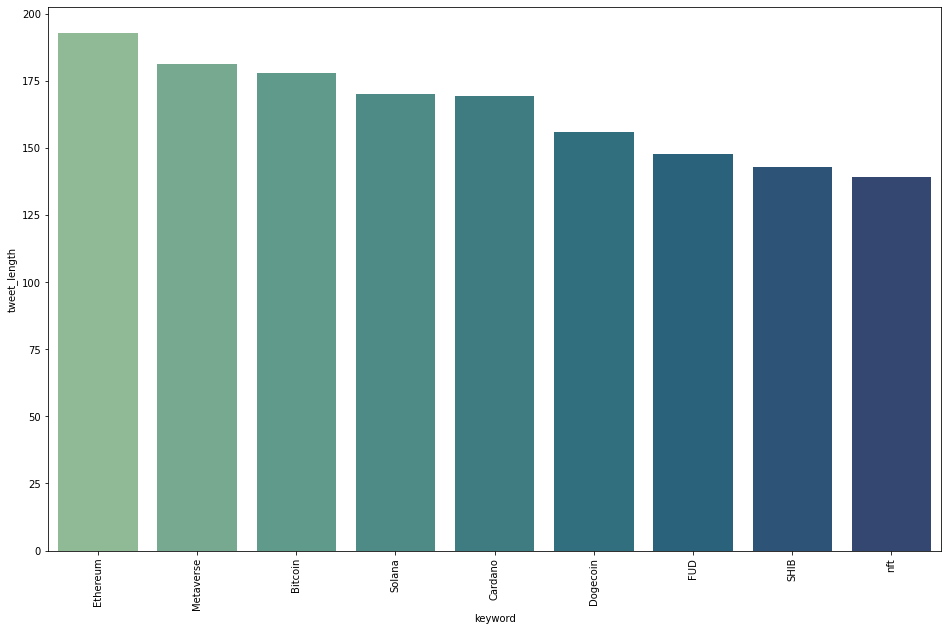

In [ ]:
tweet_lengths_by_keyword=clean_data.groupby(['keyword'])['tweet_length'].agg('mean').reset_index(inplace=False)
plt.figure(figsize=(16, 10))

g=sns.barplot(x="keyword", 
              y="tweet_length",
              palette="crest",
              order=tweet_lengths_by_keyword.sort_values("tweet_length", ascending=False).keyword, 
              data=tweet_lengths_by_keyword)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

Looks like tweets about Ethereum are on average far longer than those about nfts. Let's check boxplots to get more info.

In [ ]:
def plot_box_whisker(data, col_list):
    n_cols = len(col_list)
    
    fig, axs = plt.subplots(ncols=n_cols, nrows=1, figsize=(15, 8))
    index = 0
    axs = axs.flatten()
    
    
    for keyword in col_list:
        data_subset = data[data['keyword'] == keyword]

        sns.boxplot(y='tweet_length', data=data_subset, ax=axs[index], palette='Purples')
        axs[index].set_title(f'{keyword}')
        index = index + 1

    plt.tight_layout()

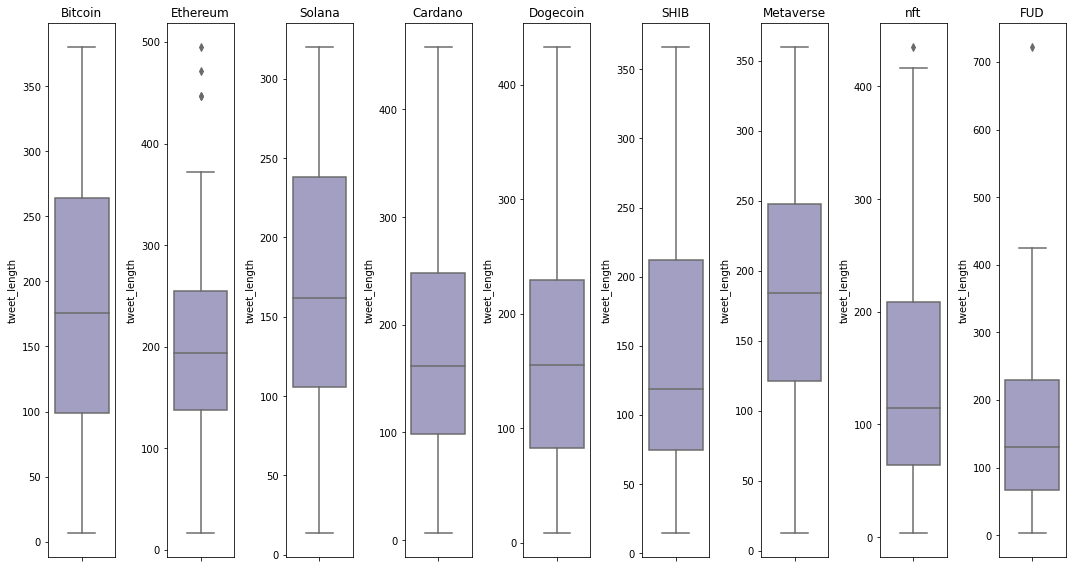

In [ ]:
plot_box_whisker(clean_data, twitter_searches) 

- Looking at the plot, we can see that tweets about Bitcoin, Solana and Cardano have Q1-Q3 range roughly between 100 and 250 characters. 
- For Ethereum and Metaverse, Q1 is higher at ~150 and ~125 characters respectively.
- For Dogecoin, SHIB, nft and FUD, Q1 is lower, under 100 characters. These also have lower Q3s at just over 200 characters.
- Generally speaking, there aren't a whole lot of outliers - they occur only for Ethereum, nft and FUD.

### Wordclouds

Last but not least, let's take a look at a couple of wordclouds - we'll have a rough idea whether the topics differ between these cryptos and crypto-related terms

In [ ]:
def _prepare_text_wordcloud(data):
    tweets = data.copy()

    # we have to remove emojis since we left them for transformers to take care of
    tweets = tweets.map(remove_emojis)

    tweets = tweets.to_list()
    tweets = [str(tweet).lower() for tweet in tweets]

    full_text = ' '.join(tweets)
    
    return full_text

Next, we have to update our stopwords

In [ ]:
stopwords = set(STOPWORDS)
stopwords.update(twitter_searches)

In [ ]:
def _generate_wordcloud_obj(data, stopwords=stopwords):
    raw_text = _prepare_text_wordcloud(data)
    
    wordcloud = WordCloud(height=500,
                          width=500,
                          background_color ='white', 
                          stopwords = stopwords, 
                          mode='RGBA',
                          min_font_size = 10).generate(raw_text)
    return wordcloud

In [ ]:
def plot_wordclouds(data, keywords, figsize=(20,18)):
    
    wordclouds = [_generate_wordcloud_obj(data[data['keyword'] == keyword]['processed_tweet']) for keyword in keywords]

    n_rows = int(len(keywords)/2)
    fig = plt.figure(figsize=figsize)

    for idx, kwrd in enumerate(keywords):
        ax = fig.add_subplot(n_rows, 3, idx+1)
        ax.set_title(label=kwrd, fontdict={"fontsize": 20})
        ax.imshow(wordclouds[idx])
        ax.axis('off')

    # plt.tight_layout()

Let's take a look at wordclouds related to different cryptocurrencies.

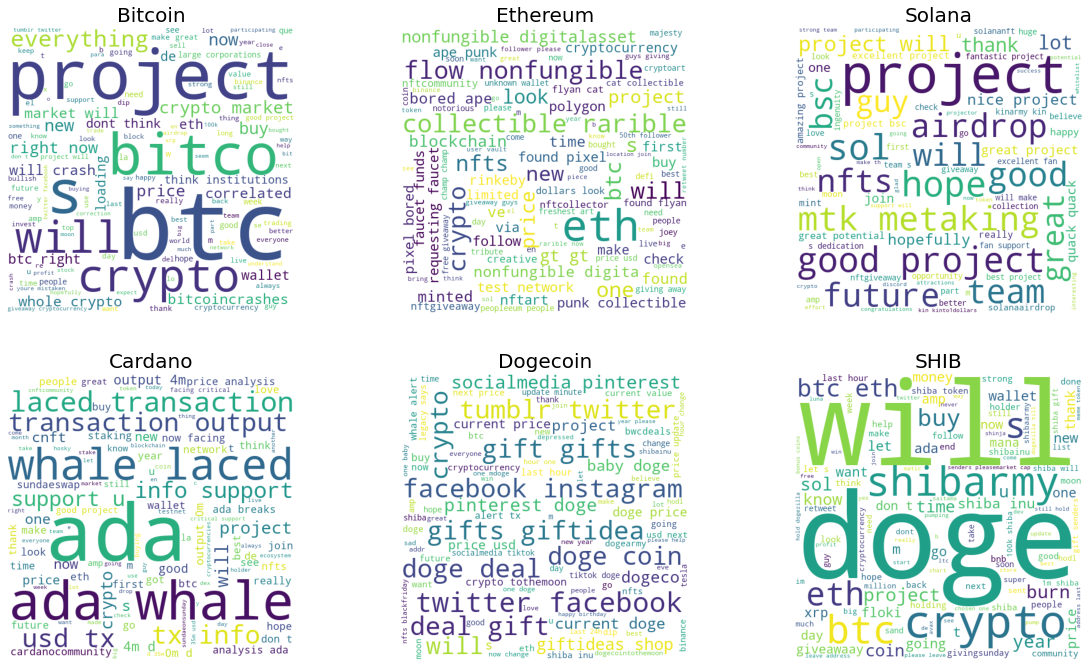

In [ ]:
plot_wordclouds(clean_data, twitter_searches[:6])

Now let's take a look at wordclouds related to different terms used in crypto community.

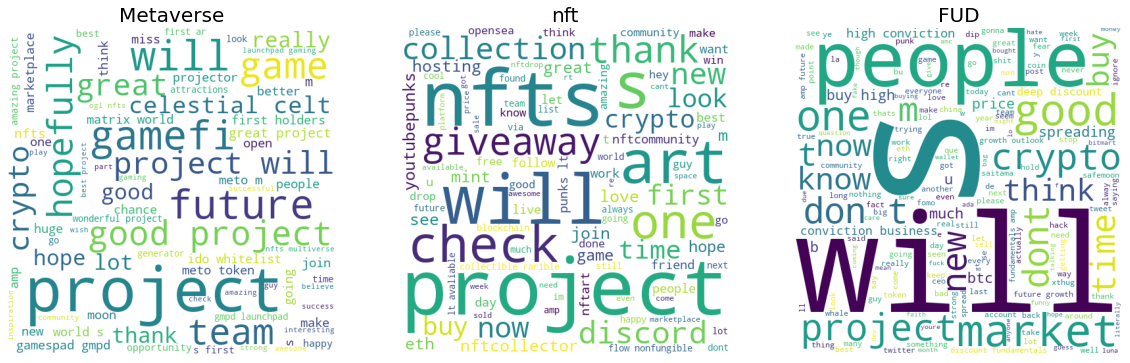

In [ ]:
plot_wordclouds(clean_data, twitter_searches[6:])

## Running Transformer models

In this section we'll focus on applying transformer models to processed tweets.

### Translation

Since we won't do any processing or get any insights here (we'll only use the provided model as is) we can use a pipeline to do the heavy lifting for us.

In [ ]:
es_en_model = 'Helsinki-NLP/opus-mt-es-en'

es_to_en_pipe = pipeline('translation', 
                         model= es_en_model, 
                         tokenizer=es_en_model)

In [ ]:
input_text = '¡Acabo de comprar Bitcoin, estoy listo para convertirme en millonario de la noche a la mañana!'

In [ ]:
input_text = 'Le dió omicron a Bitcoin y se contagiaron las altcoins'

In [ ]:
def get_translation(input_text):
    result = es_to_en_pipe(input_text)
    translated_text = result[0]['translation_text']
    return translated_text

In [ ]:
get_translation(input_text)

"I just bought Bitcoin, I'm ready to become a millionaire overnight!"

In [ ]:
def explain_translation(text, pipeline=es_to_en_pipe):
    shap_data = [input_text]
    explainer = shap.Explainer(pipeline)
    shap_values = explainer(shap_data, fixed_context=1)
    shap.plots.text(shap_values)
    
    return shap_values

In [ ]:
result_values = explain_translation(input_text, es_to_en_pipe)

  0%|          | 0/248 [00:00<?, ?it/s]

Looking at the plot above, we can see that for example word `listo` in spanish corresponds to `ready` in english (which is actually the case). Similarly, `millionaire` was split into words `million` and `aire` since it doesn't exist in the tokenizer as a whole - both of these are corresponding to the word `millonario`.

### Sentiment Analysis

Now that all of the tweets are in desired language, we can begin simple sentiment analysis.

In [ ]:
tweet_tuned_model = "finiteautomata/bertweet-base-sentiment-analysis"

tokenizer = AutoTokenizer.from_pretrained(tweet_tuned_model)
model = AutoModelForSequenceClassification.from_pretrained(tweet_tuned_model)

Let's see if any of the terms we used to search for tweets are present in our tokenizer

In [ ]:
keywords = ' '.join(twitter_searches)
keywords

'Bitcoin Ethereum Solana Cardano Dogecoin SHIB Metaverse nft FUD'

Let's check whether the keywords were previously included in the tokenizer's vocabulary

In [ ]:
def check_tokens(keyword_string):
    encoded_input = tokenizer(keywords).input_ids
    decoded_ids = [tokenizer.decode(i) for i in encoded_input]
    
    for tok_id, token in zip(encoded_input, decoded_ids):
        print(f"Token: {token}\tToken id: {tok_id}")

In [ ]:
check_tokens(keywords)

Token: < s >	Token id: 0
Token: B i t c o i n	Token id: 6635
Token: E t h e r e u m	Token id: 37320
Token: S o l @ @	Token id: 6177
Token: a n a	Token id: 1706
Token: C a r d @ @	Token id: 30556
Token: a n o	Token id: 3830
Token: D o g @ @	Token id: 18630
Token: e c o i n	Token id: 49368
Token: S H I @ @	Token id: 16686
Token: B	Token id: 633
Token: M e t a @ @	Token id: 38693
Token: v e r s e	Token id: 5593
Token: n @ @	Token id: 608
Token: f t	Token id: 1321
Token: F U @ @	Token id: 7795
Token: D	Token id: 647
Token: < / s >	Token id: 2


As you can see, the keywords bitcoin and ethereum actually appeared in the vocabulary and our tokenizer was able to recognize them. This makes sense, since these are by far the most popular cryptos. 

Let's add some custom tokens to the vocabulary - we'll add the rest of the keywords.

In [ ]:
def add_new_tokens(token_list):
    print(f"Old embedding size: {model.roberta.embeddings.word_embeddings}")

    tokenizer.add_tokens(token_list)
    model.resize_token_embeddings(len(tokenizer))
    print(f"New embedding size: {model.roberta.embeddings.word_embeddings}")

In [ ]:
crypto_tokens = ['Solana', 'Cardano', 'Dogecoin', 'SHIB', 'Metaverse', 'nft', 'FUD']

In [ ]:
add_new_tokens(crypto_tokens)

Old embedding size: Embedding(64001, 768, padding_idx=1)
New embedding size: Embedding(64008, 768)


Our tokens are now added to the tokenizer's vocabulary

In [ ]:
check_tokens(keywords)

Token: < s >	Token id: 0
Token: B i t c o i n	Token id: 6635
Token: E t h e r e u m	Token id: 37320
Token: S o l a n a	Token id: 64001
Token: C a r d a n o	Token id: 64002
Token: D o g e c o i n	Token id: 64003
Token: S H I B	Token id: 64004
Token: M e t a v e r s e	Token id: 64005
Token: n f t	Token id: 64006
Token: F U D	Token id: 64007
Token: < / s >	Token id: 2


This basically confirms it, since the corresponding ids for new tokens are the last few numbers. 

Now, let's analyze the tweet's sentiment.

In [ ]:
def get_sentiment(text, print_result=False):
    # pass the text to the tokenizer
    # print(text[:15])
    inputs = tokenizer(text, return_tensors='pt')
    
    # pass the tokenizer-processed text to the model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # getting probabilties
    scores = outputs[0][0].detach().numpy()
    scores = softmax(scores)
    scores = [np.round(float(score),4) for score in scores]
    
    # getting corresponding labels
    scores_labels = list(model.config.label2id.keys())
    
    # getting final prediction and label
    prediction = outputs.logits.argmax().item()
    final_label = model.config.id2label[prediction]
    
    # print summary
    if print_result:
        print(f"Text: {text}")
        for score, label in zip(scores, scores_labels):
            print(f"Label: {label}\tProbability: {score}")
        print(f"Sentiment: {final_label}")
    
    return max(scores), final_label

Let's run our model on some text

In [ ]:
sentence = "I just bought Bitcoin, I'm ready to become a millionaire overnight!"

In [ ]:
get_sentiment(sentence, True)

Text: I just bought Bitcoin, I'm ready to become a millionaire overnight!
Label: NEG	Probability: 0.0008
Label: NEU	Probability: 0.014
Label: POS	Probability: 0.9852
Sentiment: POS


(0.9852, 'POS')

In [ ]:
get_sentiment("🎉🎉", True)

Text: 🎉🎉
Label: NEG	Probability: 0.0271
Label: NEU	Probability: 0.9577
Label: POS	Probability: 0.0152
Sentiment: NEU


(0.9577, 'NEU')

Unfortunately, the model doesn't yet know emotes' sentiment.

Let's write a short function that will allow us to explain the analysis.

In [ ]:
def explain_sentiment(input_text, model=model, tokenizer=tokenizer):
    shap_data = [input_text]
    
    sent_pipeline = transformers.pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, return_all_scores=True)
    
    explainer = shap.Explainer(sent_pipeline)
    shap_values = explainer(shap_data, fixed_context=1)
    shap.plots.text(shap_values)
    # shap.plots.text(shap_values[:,:,"POS"])
    
    return shap_values

In [ ]:
sentence = "I just bought Bitcoin, I'm ready to become a millionaire overnight!"

In [ ]:
result_values = explain_sentiment(sentence, model, tokenizer)

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 2it [02:59, 179.32s/it]                                                                          


Looking at the results, we can see that there's 97% probability the sentence is positive. Red indicates upside and blue downside. By far the biggest contributors to this score are words `millionaire` (increases probability by almost 16%) and in this context, `exclamation mark` (increases probability by 20%). The word `overnight` however, was split into two tokens the tokenizer knows, and word `over` specifically lowers the probability of a positive sentence by only 2%

### Running the whole pipeline

Time to wrap it all up in a single pipeline to handle all the transformer models at once.

In [ ]:
def run_nlp_pipeline(data, save_results=True):
    start = time.time()
    print("Pipeline started...")
    
    result_df = data.copy()
    result_df['all_english_text'] = result_df['processed_tweet'].copy()
    
    translated_data = result_df[result_df['language'] == 'es']['all_english_text'].map(get_translation)    
    result_df.loc[translated_data.index, 'all_english_text'] = translated_data[:]
    trans_end = time.time()
    trans_elapsed_time = trans_end - start
    print(f"Translation pipeline finished in {round(trans_elapsed_time/60, 2)} minutes, {translated_data.shape[0]} tweets translated.")

    
    senti_results = result_df['processed_tweet'].map(get_sentiment)
    result_df['probability'] = [item[0] for item in senti_results]
    result_df['sentiment'] = [item[1] for item in senti_results]
    senti_end = time.time()
    senti_elapsed_time = senti_end - trans_end
    print(f"Sentiment analysis pipeline finished in {round(senti_elapsed_time/60, 2)} minutes, {result_df.shape[0]} tweets processed.")
    
    end = time.time()
    elapsed_time = end - start
    print(f"Pipeline finished in {round(elapsed_time/60, 2)} minutes.")
    
    if save_results:
        result_df.to_csv(PROCESSED_DATA_PATH + 'result_dataset' + '.csv', index=False)
    
    return result_df

Let's apply our pipeline

In [ ]:
final_df = run_nlp_pipeline(clean_data)

Pipeline started...
Translation pipeline finished in 4.99 minutes, 304 tweets translated.
Sentiment analysis pipeline finished in 24.78 minutes, 14124 tweets processed.
Pipeline finished in 29.77 minutes.


Now that the data is saved and finished, let's take a quick look at the results.

## More exploratory analysis of sentiment data

Let's load in the results

In [ ]:
results_df = pd.read_csv(PROCESSED_DATA_PATH + 'result_dataset.csv')

In [ ]:
results_df.head(5)

id        date      time         username  \
0  1467581925078544391  2021-12-05  20:49:31  satoshihoarder_   
1  1467581922914222091  2021-12-05  20:49:31      eensargencc   
2  1467581912571125766  2021-12-05  20:49:28      chardburned   
3  1467581912013492224  2021-12-05  20:49:28    angel13370372   
4  1467581911203815432  2021-12-05  20:49:28     pascalnajadi   

                 name                                              tweet  \
0  satoshihoarder.btc  DCA is the ONLY way! #Bitcoin  https://t.co/z7...   
1          Ensar Genç  Trending on #LunarCrush:  "Reasons For Calm De...   
2         chardburned  @TheLastDegree Bitcoin+gold is the ultimate pl...   
3               Fairy  @Bitcoinachu @cdixon @cameron The value of Bit...   
4       Pascal Najadi  #Bitcoin can be stored for 1000.years without ...   

  language  replies_count  retweets_count  likes_count  retweet  video  \
0       en              0               0            0    False      1   
1       en              0               0            0    False      0   
2       en              0               0            0    False      0   
3       en              0               0            0    False      0   
4       en              0               0            0    False      0   

   keyword  tweet_length  num_mentions  num_urls  num_photos  num_hashtags  \
0  Bitcoin            54             0         0           1             1   
1  Bitcoin           159             1         1           0             2   
2  Bitcoin            91             0         0           0             0   
3  Bitcoin            97             0         0           0             0   
4  Bitcoin            58             0         0           0             1   

   num_cashtags                                    processed_tweet  \
0             0                      DCA is the ONLY way! Bitcoin    
1             1  Trending on LunarCrush Reasons For Calm Despit...   
2             0   Bitcoin gold is the ultimate play Its the per...   
3             0   The value of Bitcoin can fluctuate while the ...   
4             0   Bitcoin can be stored for 1000 years without ...   

   new_length                                   all_english_text  probability  \
0          29                      DCA is the ONLY way! Bitcoin        0.9863   
1         110  Trending on LunarCrush Reasons For Calm Despit...       0.6893   
2          75   Bitcoin gold is the ultimate play Its the per...       0.8031   
3          67   The value of Bitcoin can fluctuate while the ...       0.9588   
4          58   Bitcoin can be stored for 1000 years without ...       0.8037   

  sentiment  
0       POS  
1       NEU  
2       POS  
3       NEU  
4       NEU

In [ ]:
results_df.shape

(14124, 24)

Let's take a look at the results.

<AxesSubplot:xlabel='count', ylabel='keyword'>

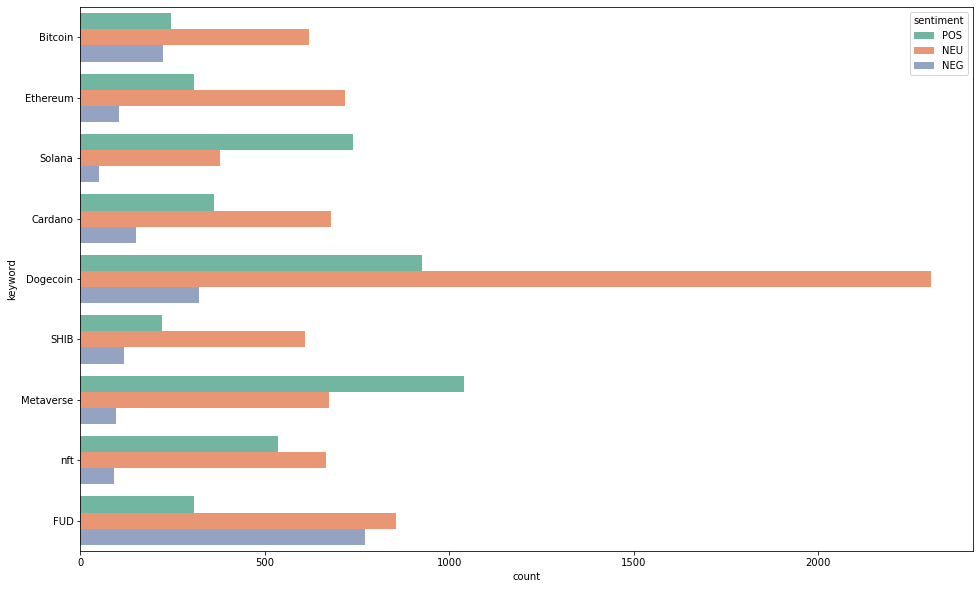

In [ ]:
plt.figure(figsize=(16, 10))
sns.countplot(y="keyword", hue="sentiment", palette="Set2", data=results_df)